# EDA on New York City Taxi Dataset presented by,

Team Members:

1.   Arth Patel
2.   Nand Patel
3.   Rishabh Gada
4. Dhruv Diyora

# Exploratory Data Analysis (EDA)

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('dataset.csv')


### Cleaning and Preprocessing

In [12]:
# 1. Convert Timestamps
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], unit='s')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], unit='s')

# 2. Check for Missing Values
missing_summary = data.isnull().sum()

# Drop rows with missing values (if any)
data.dropna(inplace=True)

# 3. Remove Duplicates
data.drop_duplicates(inplace=True)

# 4. Validate and Correct Data
# Remove trips with non-positive trip distance or amounts
data = data[(data['trip_distance'] > 0) & (data['total_amount'] > 0) & (data['fare_amount'] > 0)]

# Validate total_amount calculation (allowing small rounding errors)
data = data[np.isclose(data['total_amount'],
                        data['fare_amount'] + data['extra'] + data['mta_tax'] +
                        data['tip_amount'] + data['tolls_amount'] +
                        data['improvement_surcharge'] + data['congestion_surcharge'] +
                        data['Airport_fee'], atol=0.01)]

# 5. Add Useful Features
# Calculate trip duration in minutes
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

# Remove trips with unrealistic durations (e.g., <1 min or >24 hours)
data = data[(data['trip_duration'] > 1) & (data['trip_duration'] <= 1440)]

# 6. Clean Categorical Variables
# Ensure `store_and_fwd_flag` contains only valid values
data = data[data['store_and_fwd_flag'].isin(['Y', 'N'])]

# Map `payment_type` to more meaningful labels (example, adjust as necessary)
payment_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}
data['payment_type'] = data['payment_type'].map(payment_mapping)

# Final Summary of Cleaned Data
summary = {
    'Shape': data.shape,
    'Missing Values': data.isnull().sum().to_dict(),
    'Sample Data': data.head().to_dict()
}

# Save the cleaned data for use in EDA
data.to_csv('cleaned_dataset.csv', index=False)


Payment Type Distribution

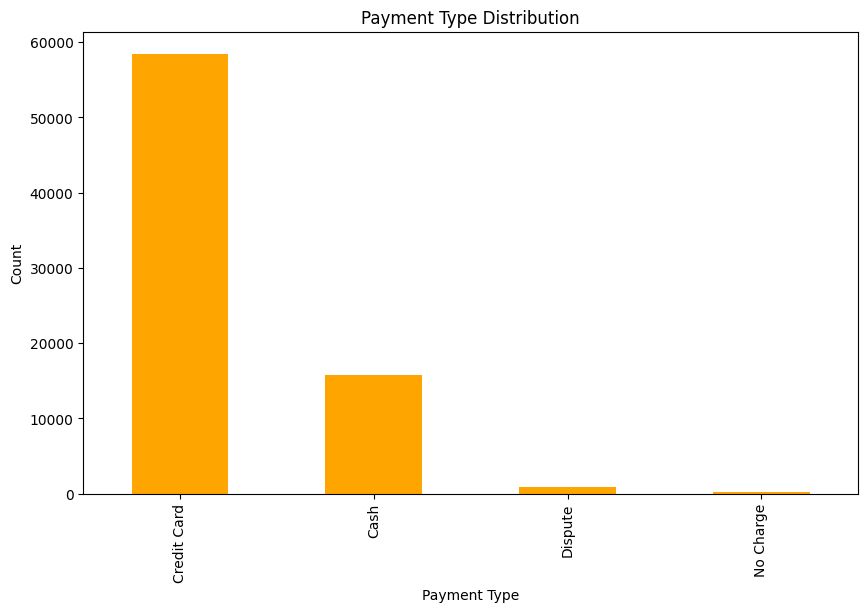

In [13]:
plt.figure(figsize=(10, 6))
payment_counts = data['payment_type'].value_counts()
payment_counts.plot(kind='bar', color='orange')
plt.title('Payment Type Distribution')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()


Trip Duration by Payment Type

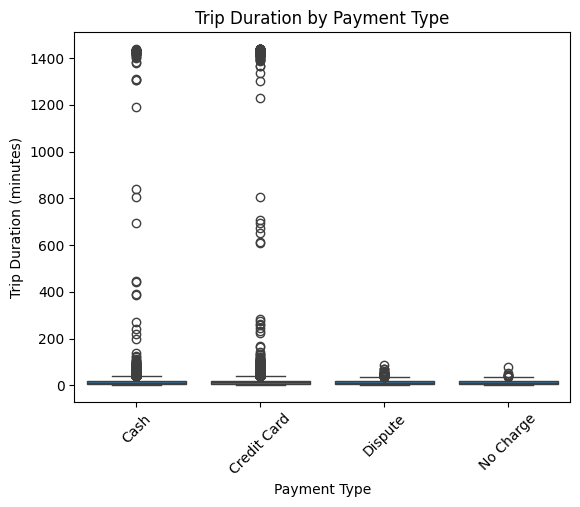

In [14]:
sns.boxplot(x='payment_type', y='trip_duration', data=data)
plt.title('Trip Duration by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Trip Duration (minutes)')
plt.xticks(rotation=45)
plt.show()


Numeric Feature Correlation Heatmap

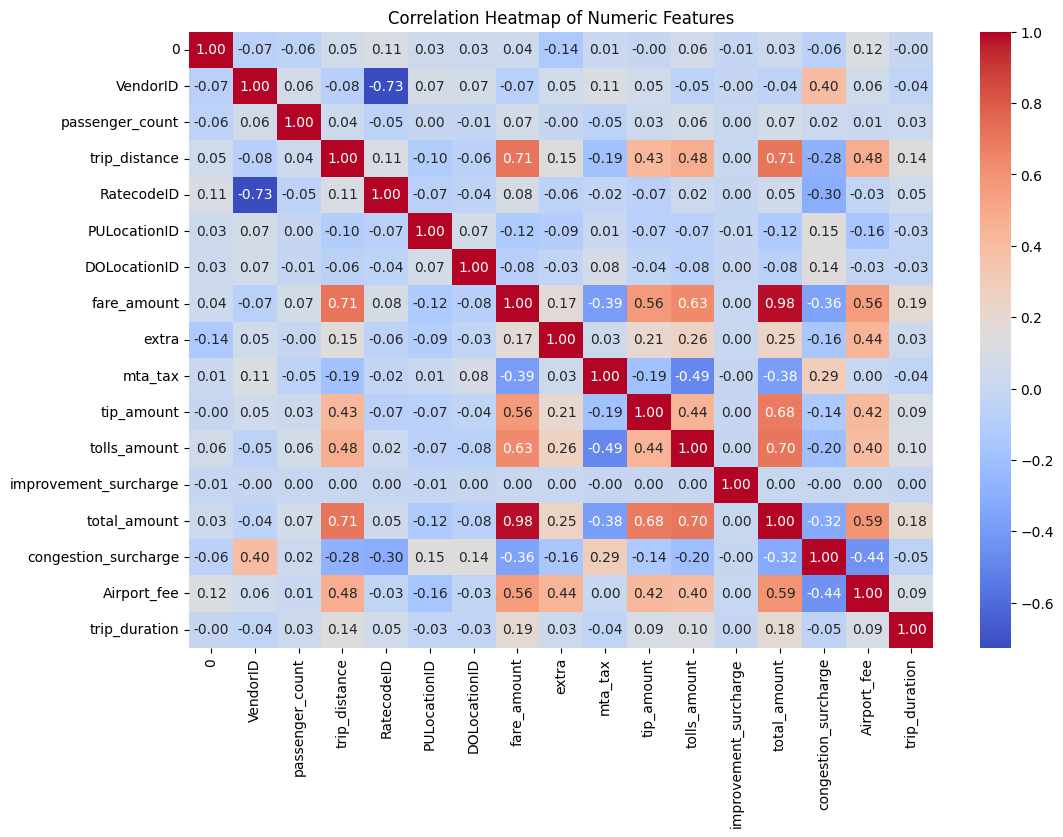

In [15]:
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


Trip Distance vs Total Amount with Passenger Count

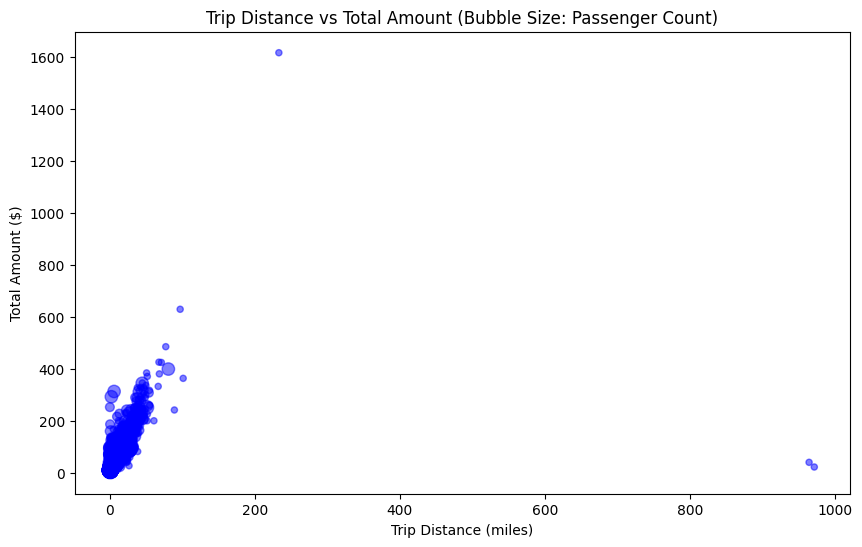

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(data['trip_distance'], data['total_amount'], s=data['passenger_count']*20, alpha=0.5, color='blue')
plt.title('Trip Distance vs Total Amount (Bubble Size: Passenger Count)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Amount ($)')
plt.show()


Pairplot (Distance, Duration, and Fare Amount)

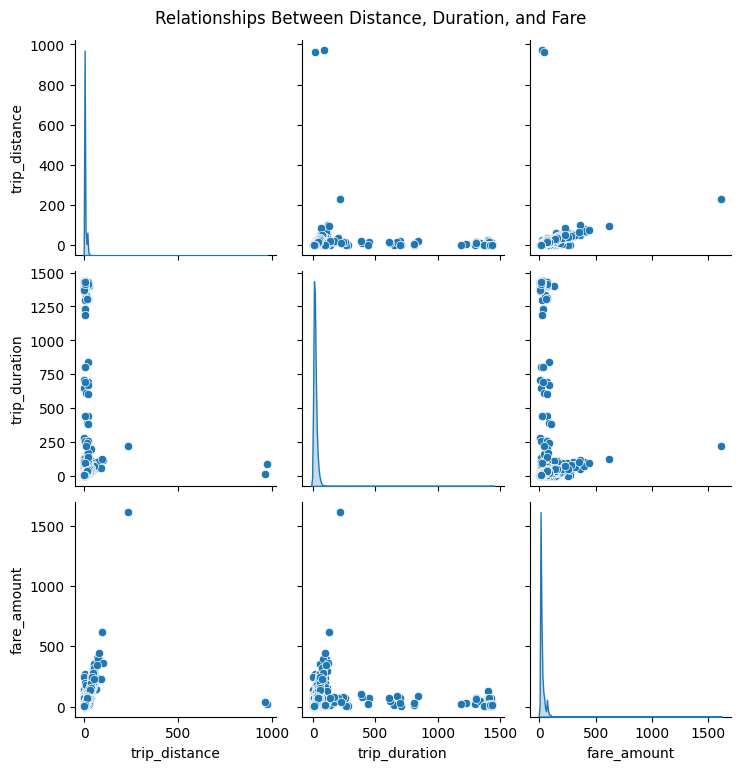

In [17]:
sns.pairplot(data, vars=['trip_distance', 'trip_duration', 'fare_amount'], diag_kind='kde')
plt.suptitle('Relationships Between Distance, Duration, and Fare', y=1.02)
plt.show()


Distribution of Total Fare Amounts (Histogram)

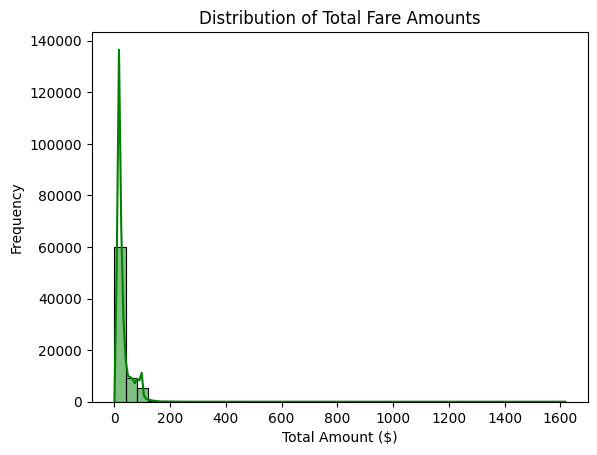

In [18]:
sns.histplot(data['total_amount'], kde=True, bins=40, color='green')
plt.title('Distribution of Total Fare Amounts')
plt.xlabel('Total Amount ($)')
plt.ylabel('Frequency')
plt.show()


Vendor Share

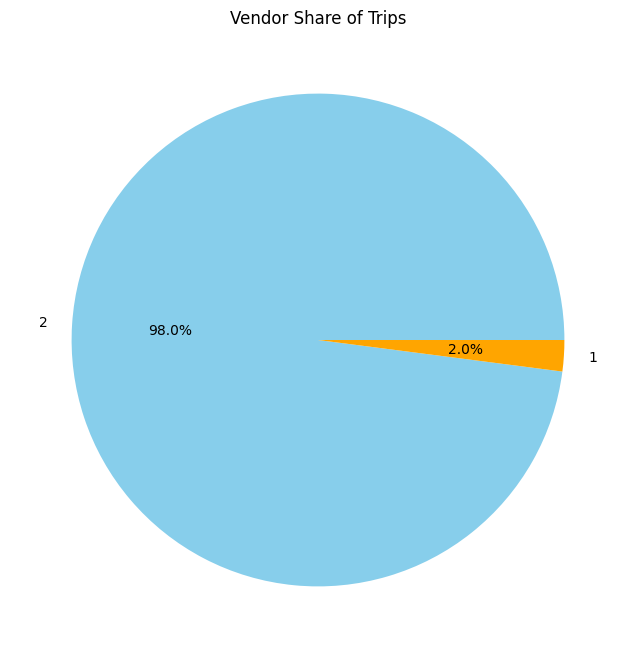

In [19]:
vendor_counts = data['VendorID'].value_counts()
plt.figure(figsize=(8, 8))
vendor_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'orange'])
plt.title('Vendor Share of Trips')
plt.ylabel('')
plt.show()


Passenger Count Distribution

<ipython-input-20-cd0a56e12030>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='passenger_count', data=data, palette='pastel')


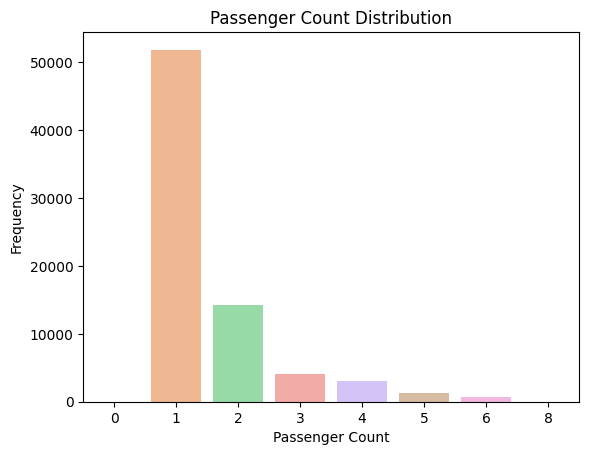

In [20]:
sns.countplot(x='passenger_count', data=data, palette='pastel')
plt.title('Passenger Count Distribution')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()


Fare Amount Distribution

<ipython-input-21-6e783a2901f7>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['fare_amount'], shade=True, color='purple')


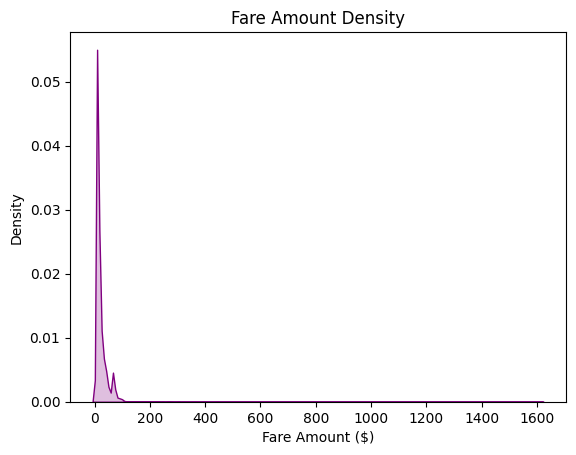

In [21]:
sns.kdeplot(data['fare_amount'], shade=True, color='purple')
plt.title('Fare Amount Density')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Density')
plt.show()

3D Scatter Plot (Distance, Duration, and Fare Amount)

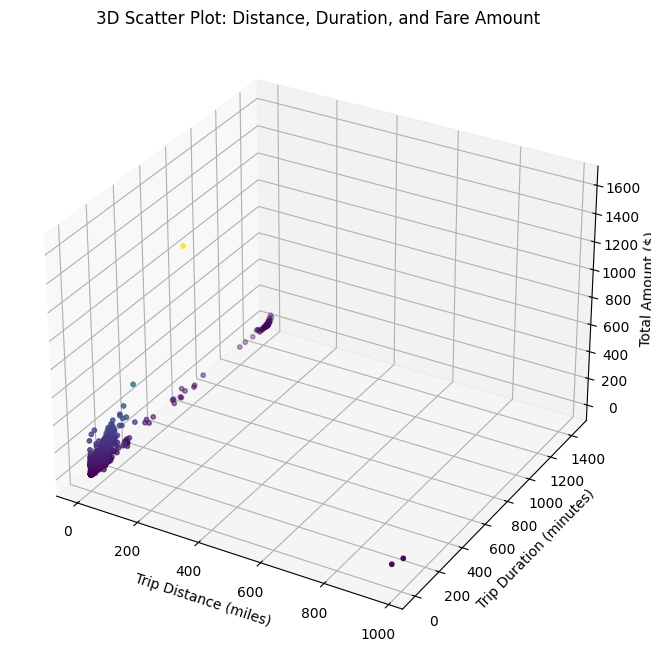

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['trip_distance'], data['trip_duration'], data['total_amount'],
           c=data['total_amount'], cmap='viridis', s=10)
ax.set_xlabel('Trip Distance (miles)')
ax.set_ylabel('Trip Duration (minutes)')
ax.set_zlabel('Total Amount ($)')
plt.title('3D Scatter Plot: Distance, Duration, and Fare Amount')
plt.show()


## Machine Learning Models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize


# Load and preprocess the data
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], unit='s')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], unit='s')

# Select features for prediction tasks
regression_features = ['trip_distance', 'fare_amount', 'extra', 'mta_tax']
X_regression = data[regression_features]
y_regression = data['total_amount']

classification_features = regression_features
X_classification = data[classification_features]
y_classification = data['payment_type']

# Split the data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Stratified split for classification to ensure class balance
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_split.split(X_classification, y_classification):
    X_train_class = X_classification.iloc[train_index]
    X_test_class = X_classification.iloc[test_index]
    y_train_class = y_classification.iloc[train_index]
    y_test_class = y_classification.iloc[test_index]


### Linear Regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


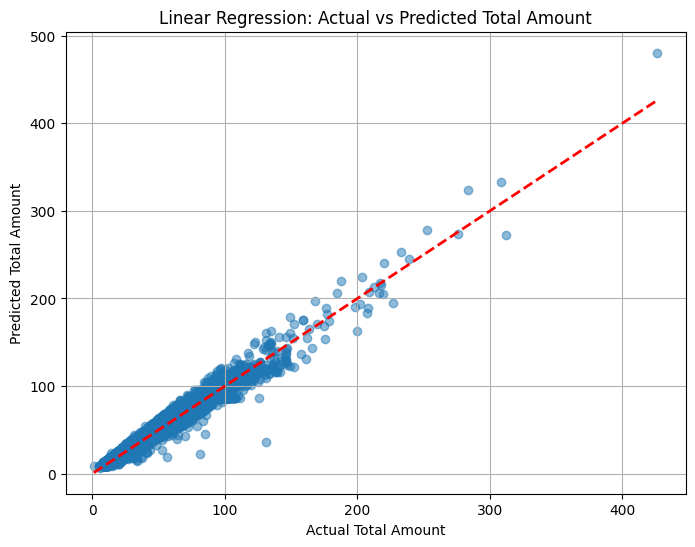

In [3]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = lin_reg.predict(X_test_reg)
regression_rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)

# Linear Regression Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', linewidth=2)
plt.title("Linear Regression: Actual vs Predicted Total Amount")
plt.xlabel("Actual Total Amount")
plt.ylabel("Predicted Total Amount")
plt.grid(True)
plt.show()


### Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use

<Figure size 800x600 with 0 Axes>

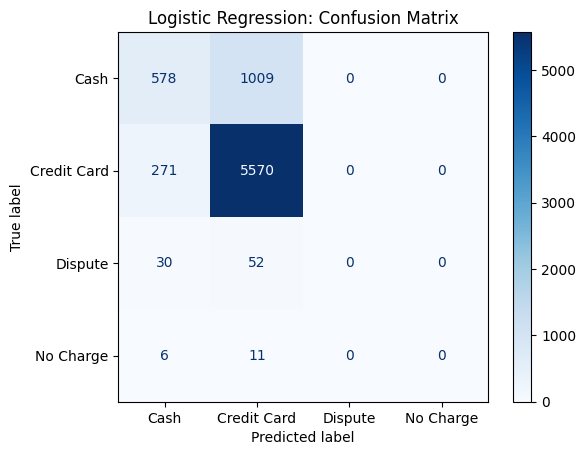

Classification Report:
               precision    recall  f1-score   support

        Cash       0.65      0.36      0.47      1587
 Credit Card       0.84      0.95      0.89      5841
     Dispute       0.00      0.00      0.00        82
   No Charge       0.00      0.00      0.00        17

    accuracy                           0.82      7527
   macro avg       0.37      0.33      0.34      7527
weighted avg       0.79      0.82      0.79      7527



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


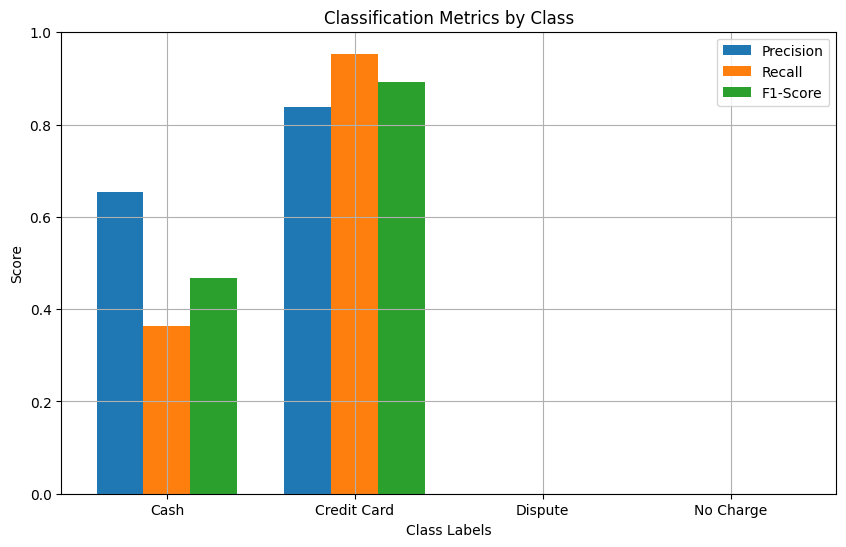

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the dataset
data_half = data.sample(frac=0.5, random_state=42)  # Use half of the dataset

# Define features and target
features = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'total_amount']
target = 'payment_type'

X_half = data_half[features]
y_half = data_half[target]

# Scale features
scaler = StandardScaler()
X_scaled_half = scaler.fit_transform(X_half)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_half, y_half, test_size=0.2, random_state=42, stratify=y_half)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=500, random_state=42, solver='saga')
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Model Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=log_reg.classes_).plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression: Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", class_report)

# Visualization: Classification Metrics
# Calculate precision, recall, and f1-score for each class
labels = log_reg.classes_
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=labels)

# Bar chart for metrics
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.xlabel("Class Labels")
plt.ylabel("Score")
plt.title("Classification Metrics by Class")
plt.xticks(x, labels)
plt.legend()
plt.grid(True)
plt.show()


### Decision Tree

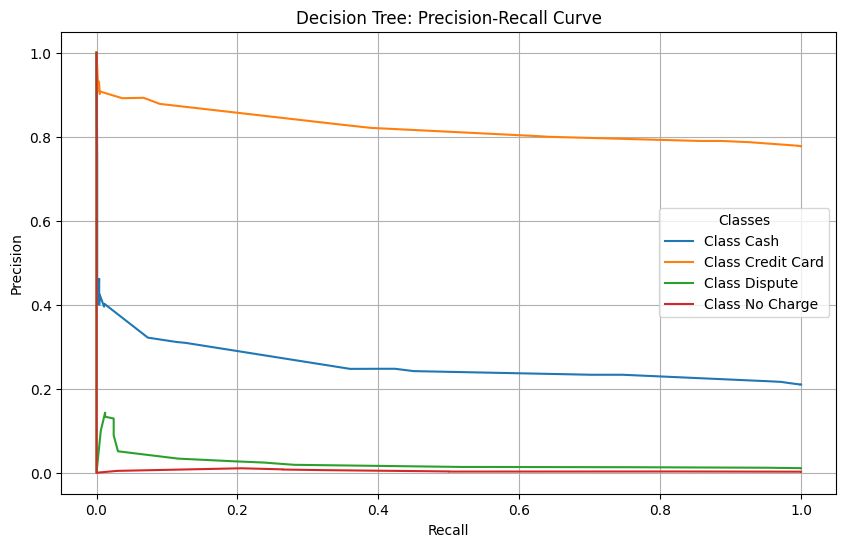

Decision Tree Accuracy: 0.78


In [10]:

# Train the Decision Tree model
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree.fit(X_train_class, y_train_class)  # Train the model
y_pred_tree = decision_tree.predict(X_test_class)  # Make predictions
y_pred_prob = decision_tree.predict_proba(X_test_class)  # Get class probabilities

# Binarize the target labels for multi-class precision-recall
y_test_binarized = label_binarize(y_test_class, classes=decision_tree.classes_)

# Precision-Recall Curve Visualization
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(decision_tree.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")

plt.title("Decision Tree: Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(title="Classes")
plt.grid(True)
plt.show()

# Print Model Accuracy
decision_tree_accuracy = accuracy_score(y_test_class, y_pred_tree)
print(f"Decision Tree Accuracy: {decision_tree_accuracy:.2f}")



### Random Forest

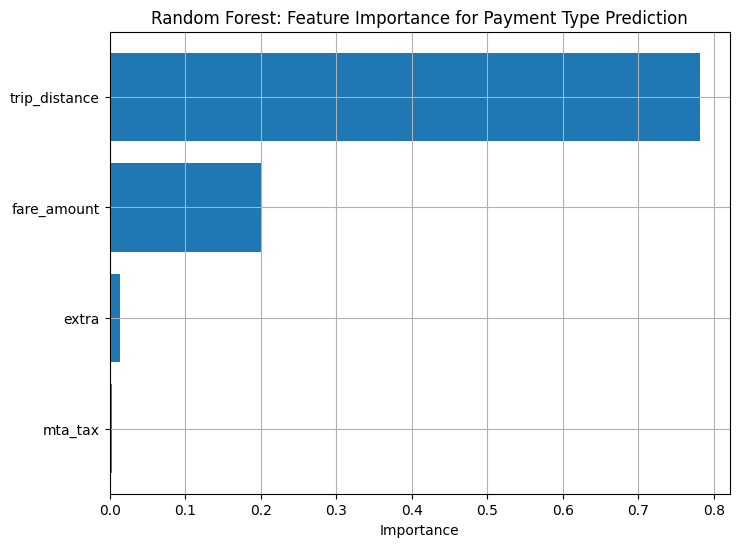

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_class, y_train_class)
y_pred_rf = random_forest.predict(X_test_class)
random_forest_accuracy = accuracy_score(y_test_class, y_pred_rf)

# Random Forest Visualization
feature_importances = random_forest.feature_importances_
sorted_indices = np.argsort(feature_importances)
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), np.array(classification_features)[sorted_indices])
plt.title("Random Forest: Feature Importance for Payment Type Prediction")
plt.xlabel("Importance")
plt.grid(True)
plt.show()


## Summaize Results

In [ ]:
# Summarize Results
results_summary = {
    'Model': ['Linear Regression', 'Logistic Regression (Half Dataset)', 'Decision Tree', 'Random Forest'],
    'Performance Metric': ['RMSE', 'Accuracy', 'Accuracy', 'Accuracy'],
    'Value': [regression_rmse, accuracy_score(y_test, y_pred), decision_tree_accuracy, random_forest_accuracy]
}

results_df = pd.DataFrame(results_summary)

# Display Results
print("Model Performance Summary:")
print(results_df)


Model Performance Summary:
                                Model Performance Metric     Value
0                   Linear Regression               RMSE  4.434801
1  Logistic Regression (Half Dataset)           Accuracy  0.816793
2                       Decision Tree           Accuracy  0.777003
3                       Random Forest           Accuracy  0.736017
